# "Concevez une application au service de la santé publique"
_Cleaning Notebook_
13/08 16h

### Importing Modules

In [0]:
## IMPORTATIONS
import pandas as pd
import pandas_profiling
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

import numpy as np
import matplotlib.pyplot as plt
% matplotlib inline
import seaborn as sns
sns.set_style("whitegrid")

import scipy.stats as st

from google.colab import files

import sys
sys.executable # 'C:\\ProgramData\\Anaconda3\\python.exe'

'/usr/bin/python3'

In [0]:
# %pip install jupyternotify
# import jupyternotify
# ip = get_ipython()
# ip.register_magics(jupyternotify.JupyterNotifyMagics)

### Defining functions

In [0]:
def Diff(tab1, tab2): 
    #tab_dif = [i for i in tab1 + tab2 if i not in tab1 or i not in tab2]
    return (set(tab1)-set(tab2),set(tab2)-set(tab1))

In [0]:
def info (df):
    nb_li = df.shape[0]
    nb_co = df.shape[1]
    t = np.empty(nb_li)
    t.fill(nb_li)
    df_l_null = pd.DataFrame(df.T.isna().sum()) # number of null per row
    df_c_null = pd.DataFrame(df.isna().sum()) # number of null per column
    
    # number of rows without any 'null'
    al = len([x for x in df_l_null[0] if x==0])
    nb_ss_null = pd.DataFrame([al]).rename(index={0:'row_wo_null'}).T
    pct_ss_null = pd.DataFrame([al*100/nb_li]).rename(index={0:'row_wo_null'}).T
    # number of rows with all 'null'
    bl = len([x for x in df_l_null[0] if x==nb_co])
    nb_null = pd.DataFrame([bl]).rename(index={0:'row_null'}).T
    pct_null = pd.DataFrame([bl*100/nb_li]).rename(index={0:'row_null'}).T
    # number of mixed rows (with some null)
    cl = len([x for x in df_l_null[0] if (x!=0 and x!=nb_co)])
    nb_mix = pd.DataFrame([cl]).rename(index={0:'row_mix'}).T
    pct_mix = pd.DataFrame([cl*100/nb_li]).rename(index={0:'row_mix'}).T
    info_nb = pd.concat([nb_ss_null, nb_null,
                         nb_mix],axis=1, sort=False).rename(index={0:'nb'})
    info_pct = pd.concat([pct_ss_null, pct_null,
                          pct_mix],axis=1, sort=False).rename(index={0:'pct'})
    info_l = pd.concat([info_nb,info_pct], sort=False)
    # total number of rows
    info_l["row_tot"] = [info_l.T['nb'].sum(), info_l.T['pct'].sum()]
    
    # number of columns without any 'null''
    ac = len([x for x in df_c_null[0] if x==0])
    nb_ss_null = pd.DataFrame([ac]).rename(index={0:'col_wo_null'}).T
    pct_ss_null = pd.DataFrame([ac*100/nb_co]).rename(index={0:'col_wo_null'}).T
    # number of columns with all 'null'
    bc = len([x for x in df_c_null[0] if x==nb_li])
    nb_null = pd.DataFrame([bc]).rename(index={0:'col_null'}).T
    pct_null = pd.DataFrame([bc*100/nb_co]).rename(index={0:'col_null'}).T
    # number of mixed columns (with some null)
    cc = len([x for x in df_c_null[0] if (x!=0 and x!=nb_li)])
    nb_mix = pd.DataFrame([cc]).rename(index={0:'col_mix'}).T
    pct_mix = pd.DataFrame([cc*100/nb_co]).rename(index={0:'col_mix'}).T
    info_nb = pd.concat([nb_ss_null, nb_null,
                         nb_mix],axis=1, sort=False).rename(index={0:'nb'})
    info_pct = pd.concat([pct_ss_null, pct_null, pct_mix],
                         axis=1, sort=False).rename(index={0:'pct'})
    info_c = pd.concat([info_nb,info_pct], sort=False)
    # total number of columns
    info_c["col_tot"] = [info_c.T['nb'].sum(), info_c.T['pct'].sum()]
    
    info = pd.concat([info_l,info_c], axis=1, sort=False)
    
    return info

In [0]:
def desc_bis (df):
    nb_li = df.index.size
    nb_col = df.columns.size
    tot = nb_li*nb_col    
    info = pd.DataFrame(df.dtypes).T.rename(index={0:'type'}) 
    info = info.append(pd.DataFrame(df.isna().sum()).T.rename(index={0:'null'}))
    return info

In [0]:
def eval_null (inf_df):
    a = inf_df.T['null'].sum()
    b = inf_df.T['count'].sum()
    print("Number of 'null' values: {:.0f}".format(a))
    print("Number of values (without 'null'): {:.0f}".format(b))
    print("Total number of cells: {:.0f}".format(a+b))
    print("Total number of 'null' (pct): {:.1f}%".format(a*100/(a+b)))

### Importing dataset

In [0]:
# On my PC: Import data from csv (part or all of the rows)
#filepath = '../DATA/en.openfoodfacts.org.products.csv'
#df = pd.read_csv(filepath, sep='\t', low_memory=False, encoding ='utf-8')
#df = pd.read_csv(filepath, sep='\t',nrows=500000, low_memory=False, encoding ='utf-8')

In [0]:
# On Google Colab (1): Upload a file from my drive
# from google.colab import files
# import io
# uploaded = files.upload()
# df = pd.read_csv(io.BytesIO(df['en.openfoodfacts.org.products.csv']))

In [0]:
# On Google Colab (2): Upload a file from Google Drive via PyDrive
# Install PyDrive wrapper & import libraries (once)
!pip install -U -q PyDrive 
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create PyDrive client (once)
auth.authenticate_user() 
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
# Download a file based on its file ID (shareable link)
file_id = '1Ua1RzJPjLAaDg9kgz3SmusmGoUO53OOx'
downloaded = drive.CreateFile({'id': file_id})

In [0]:
downloaded.GetContentFile('en.openfoodfacts.org.products.csv')  
df = pd.read_csv('en.openfoodfacts.org.products.csv',
                 sep='\t', low_memory=False, encoding ='utf-8')  # nrows=1000,

In [0]:
df.head(2)

,code,url,creator,created_t,created_datetime,last_modified_t,last_modified_datetime,product_name,generic_name,quantity,packaging,packaging_tags,brands,brands_tags,categories,categories_tags,categories_en,origins,origins_tags,manufacturing_places,manufacturing_places_tags,labels,labels_tags,labels_en,emb_codes,emb_codes_tags,first_packaging_code_geo,cities,cities_tags,purchase_places,stores,countries,countries_tags,countries_en,ingredients_text,allergens,allergens_en,traces,traces_tags,traces_en,serving_size,serving_quantity,no_nutriments,additives_n,additives,additives_tags,additives_en,ingredients_from_palm_oil_n,ingredients_from_palm_oil,ingredients_from_palm_oil_tags,ingredients_that_may_be_from_palm_oil_n,ingredients_that_may_be_from_palm_oil,ingredients_that_may_be_from_palm_oil_tags,nutrition_grade_fr,nova_group,pnns_groups_1,pnns_groups_2,states,states_tags,states_en,main_category,main_category_en,image_url,image_small_url,image_ingredients_url,image_ingredients_small_url,image_nutrition_url,image_nutrition_small_url,energy_100g,energy-from-fat_100g,fat_100g,saturated-fat_100g,-butyric-acid_100g,-caproic-acid_100g,-caprylic-acid_100g,-capric-acid_100g,-lauric-acid_100g,-myristic-acid_100g,-palmitic-acid_100g,-stearic-acid_100g,-arachidic-acid_100g,-behenic-acid_100g,-lignoceric-acid_100g,-cerotic-acid_100g,-montanic-acid_100g,-melissic-acid_100g,monounsaturated-fat_100g,polyunsaturated-fat_100g,omega-3-fat_100g,-alpha-linolenic-acid_100g,-eicosapentaenoic-acid_100g,-docosahexaenoic-acid_100g,omega-6-fat_100g,-linoleic-acid_100g,-arachidonic-acid_100g,-gamma-linolenic-acid_100g,-dihomo-gamma-linolenic-acid_100g,omega-9-fat_100g,-oleic-acid_100g,-elaidic-acid_100g,-gondoic-acid_100g,-mead-acid_100g,-erucic-acid_100g,-nervonic-acid_100g,trans-fat_100g,cholesterol_100g,carbohydrates_100g,sugars_100g,-sucrose_100g,-glucose_100g,-fructose_100g,-lactose_100g,-maltose_100g,-maltodextrins_100g,starch_100g,polyols_100g,fiber_100g,proteins_100g,casein_100g,serum-proteins_100g,nucleotides_100g,salt_100g,sodium_100g,alcohol_100g,vitamin-a_100g,beta-carotene_100g,vitamin-d_100g,vitamin-e_100g,vitamin-k_100g,vitamin-c_100g,vitamin-b1_100g,vitamin-b2_100g,vitamin-pp_100g,vitamin-b6_100g,vitamin-b9_100g,folates_100g,vitamin-b12_100g,biotin_100g,pantothenic-acid_100g,silica_100g,bicarbonate_100g,potassium_100g,chloride_100g,calcium_100g,phosphorus_100g,iron_100g,magnesium_100g,zinc_100g,copper_100g,manganese_100g,fluoride_100g,selenium_100g,chromium_100g,molybdenum_100g,iodine_100g,caffeine_100g,taurine_100g,ph_100g,fruits-vegetables-nuts_100g,fruits-vegetables-nuts-dried_100g,fruits-vegetables-nuts-estimate_100g,collagen-meat-protein-ratio_100g,cocoa_100g,chlorophyl_100g,carbon-footprint_100g,carbon-footprint-from-meat-or-fish_100g,nutrition-score-fr_100g,nutrition-score-uk_100g,glycemic-index_100g,water-hardness_100g,choline_100g,phylloquinone_100g,beta-glucan_100g,inositol_100g,carnitine_100g
0,0000000000000010,http://world-en.openfoodfacts.org/product/0000...,openfoodfacts-contributors,1550246813,2019-02-15T16:06:53Z,1550246813,2019-02-15T16:06:53Z,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,en:FR,en:france,France,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,unknown,unknown,"en:empty, en:to-be-completed, en:nutrition-fac...","en:empty,en:to-be-completed,en:nutrition-facts...","Empty,To be completed,Nutrition facts to be co...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,000000000000010,http://world-en.openfoodfacts.org/product/0000...

### Description

In [0]:
# Shape of the dataset
df.shape

(954463, 175)

In [0]:
desc_df_all = desc_bis(df).append(df.describe(include='all'))
desc_df_all

,code,url,creator,created_t,created_datetime,last_modified_t,last_modified_datetime,product_name,generic_name,quantity,packaging,packaging_tags,brands,brands_tags,categories,categories_tags,categories_en,origins,origins_tags,manufacturing_places,manufacturing_places_tags,labels,labels_tags,labels_en,emb_codes,emb_codes_tags,first_packaging_code_geo,cities,cities_tags,purchase_places,stores,countries,countries_tags,countries_en,ingredients_text,allergens,allergens_en,traces,traces_tags,traces_en,serving_size,serving_quantity,no_nutriments,additives_n,additives,additives_tags,additives_en,ingredients_from_palm_oil_n,ingredients_from_palm_oil,ingredients_from_palm_oil_tags,ingredients_that_may_be_from_palm_oil_n,ingredients_that_may_be_from_palm_oil,ingredients_that_may_be_from_palm_oil_tags,nutrition_grade_fr,nova_group,pnns_groups_1,pnns_groups_2,states,states_tags,states_en,main_category,main_category_en,image_url,image_small_url,image_ingredients_url,image_ingredients_small_url,image_nutrition_url,image_nutrition_small_url,energy_100g,energy-from-fat_100g,fat_100g,saturated-fat_100g,-butyric-acid_100g,-caproic-acid_100g,-caprylic-acid_100g,-capric-acid_100g,-lauric-acid_100g,-myristic-acid_100g,-palmitic-acid_100g,-stearic-acid_100g,-arachidic-acid_100g,-behenic-acid_100g,-lignoceric-acid_100g,-cerotic-acid_100g,-montanic-acid_100g,-melissic-acid_100g,monounsaturated-fat_100g,polyunsaturated-fat_100g,omega-3-fat_100g,-alpha-linolenic-acid_100g,-eicosapentaenoic-acid_100g,-docosahexaenoic-acid_100g,omega-6-fat_100g,-linoleic-acid_100g,-arachidonic-acid_100g,-gamma-linolenic-acid_100g,-dihomo-gamma-linolenic-acid_100g,omega-9-fat_100g,-oleic-acid_100g,-elaidic-acid_100g,-gondoic-acid_100g,-mead-acid_100g,-erucic-acid_100g,-nervonic-acid_100g,trans-fat_100g,cholesterol_100g,carbohydrates_100g,sugars_100g,-sucrose_100g,-glucose_100g,-fructose_100g,-lactose_100g,-maltose_100g,-maltodextrins_100g,starch_100g,polyols_100g,fiber_100g,proteins_100g,casein_100g,serum-proteins_100g,nucleotides_100g,salt_100g,sodium_100g,alcohol_100g,vitamin-a_100g,beta-carotene_100g,vitamin-d_100g,vitamin-e_100g,vitamin-k_100g,vitamin-c_100g,vitamin-b1_100g,vitamin-b2_100g,vitamin-pp_100g,vitamin-b6_100g,vitamin-b9_100g,folates_100g,vitamin-b12_100g,biotin_100g,pantothenic-acid_100g,silica_100g,bicarbonate_100g,potassium_100g,chloride_100g,calcium_100g,phosphorus_100g,iron_100g,magnesium_100g,zinc_100g,copper_100g,manganese_100g,fluoride_100g,selenium_100g,chromium_100g,molybdenum_100g,iodine_100g,caffeine_100g,taurine_100g,ph_100g,fruits-vegetables-nuts_100g,fruits-vegetables-nuts-dried_100g,fruits-vegetables-nuts-estimate_100g,collagen-meat-protein-ratio_100g,cocoa_100g,chlorophyl_100g,carbon-footprint_100g,carbon-footprint-from-meat-or-fish_100g,nutrition-score-fr_100g,nutrition-score-uk_100g,glycemic-index_100g,water-hardness_100g,choline_100g,phylloquinone_100g,beta-glucan_100g,inositol_100g,carnitine_100g
type,object,object,object,int64,object,int64,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,float64,object,object,object,object,object,object,object,object,float64,object,object,object,object,float64,float64,float64,object,object,object,float64,float64,object,float64,float64,object,object,float64,object,object,object,object,object,object,object,object,object,object,object,object,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float

In [0]:
desc_df_num = df.describe(include=['int64', 'float64'])
desc_df_num = desc_bis(df[desc_df_num.columns]).append(desc_df_num)
desc_df_num

,created_t,last_modified_t,cities,allergens_en,serving_quantity,no_nutriments,additives_n,ingredients_from_palm_oil_n,ingredients_from_palm_oil,ingredients_that_may_be_from_palm_oil_n,ingredients_that_may_be_from_palm_oil,nova_group,energy_100g,energy-from-fat_100g,fat_100g,saturated-fat_100g,-butyric-acid_100g,-caproic-acid_100g,-caprylic-acid_100g,-capric-acid_100g,-lauric-acid_100g,-myristic-acid_100g,-palmitic-acid_100g,-stearic-acid_100g,-arachidic-acid_100g,-behenic-acid_100g,-lignoceric-acid_100g,-cerotic-acid_100g,-montanic-acid_100g,-melissic-acid_100g,monounsaturated-fat_100g,polyunsaturated-fat_100g,omega-3-fat_100g,-alpha-linolenic-acid_100g,-eicosapentaenoic-acid_100g,-docosahexaenoic-acid_100g,omega-6-fat_100g,-linoleic-acid_100g,-arachidonic-acid_100g,-gamma-linolenic-acid_100g,-dihomo-gamma-linolenic-acid_100g,omega-9-fat_100g,-oleic-acid_100g,-elaidic-acid_100g,-gondoic-acid_100g,-mead-acid_100g,-erucic-acid_100g,-nervonic-acid_100g,trans-fat_100g,cholesterol_100g,carbohydrates_100g,sugars_100g,-sucrose_100g,-glucose_100g,-fructose_100g,-lactose_100g,-maltose_100g,-maltodextrins_100g,starch_100g,polyols_100g,fiber_100g,proteins_100g,casein_100g,serum-proteins_100g,nucleotides_100g,salt_100g,sodium_100g,alcohol_100g,vitamin-a_100g,beta-carotene_100g,vitamin-d_100g,vitamin-e_100g,vitamin-k_100g,vitamin-c_100g,vitamin-b1_100g,vitamin-b2_100g,vitamin-pp_100g,vitamin-b6_100g,vitamin-b9_100g,folates_100g,vitamin-b12_100g,biotin_100g,pantothenic-acid_100g,silica_100g,bicarbonate_100g,potassium_100g,chloride_100g,calcium_100g,phosphorus_100g,iron_100g,magnesium_100g,zinc_100g,copper_100g,manganese_100g,fluoride_100g,selenium_100g,chromium_100g,molybdenum_100g,iodine_100g,caffeine_100g,taurine_100g,ph_100g,fruits-vegetables-nuts_100g,fruits-vegetables-nuts-dried_100g,fruits-vegetables-nuts-estimate_100g,collagen-meat-protein-ratio_100g,cocoa_100g,chlorophyl_100g,carbon-footprint_100g,carbon-footprint-from-meat-or-fish_100g,nutrition-score-fr_100g,nutrition-score-uk_100g,glycemic-index_100g,water-hardness_100g,choline_100g,phylloquinone_100g,beta-glucan_100g,inositol_100g,carnitine_100g
type,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
null,0,0,954463,954463,682531,954463,514866,514866,954463,514866,954463,643286,210296,953515,215300,244643,954462,954463,954462,954459,954456,954462,954460,954462,954460,954462,954463,954460,954462,954463,930236,930182,952977,954176,954367,954335,954114,954266,954448,954460,954462,954426,954443,954463,954463,954463,954463,954463,810237,809488,215249,229028,954346,954415,954397,954071,954454,954449,954086,953706,657730,213026,954425,954429,954451,233245,233264,942914,815582,954394,946223,952122,953447,812038,942208,942726,941892,946687,948492,951384,948267,953935,951494,954362,954209,928452,953971,808966,947797,811984,946796,949966,952177,952613,954241,953148,954408,954405,953891,954242,954379,954325,948739,954190,945024,954177,950074,954461,954061,945394,688644,688644,954460,954463,954433,954460,954443,954427,954448
count,954463,954463,0,0,271932,0,439597,439597,0,439597,0,311177,744167,948,739163,70982

In [0]:
dfcopy = df.copy(deep = True)

In [0]:
# On Google Colab
profile = pandas_profiling.ProfileReport(dfcopy) #, check_correlation = False

# On my PC
#profile = dfcopy.profile_report(dfcopy, check_correlation = False)
# profile = dfcopy.profile_report(title="OpenFoodFacts dataset",
#                                 style={'full_width':True},
#                                 correlations={'pearson': True,
#                                               'spearman': False,
#                                               'kendall': False,     
#                                               'phi_k': False,
#                                               'cramers': False,
#                                               'recoded': False},
#                                 plot ={'histogram':{'bayesian_blocks_bins': False, 'bins': 12}},
#                                )

In [0]:
profile.to_file("OFFacts_report2_2.html")
profile

Output hidden; open in https://colab.research.google.com to view.

In [0]:
rejected_variables_95 = profile.get_rejected_variables(threshold=0.95)
rejected_variables_90 = profile.get_rejected_variables(threshold=0.9)
Diff(rejected_variables_90, rejected_variables_95), len(rejected_variables_90), len(rejected_variables_95)

(({'-lactose_100g',
   'choline_100g',
   'copper_100g',
   'folates_100g',
   'fruits-vegetables-nuts-dried_100g',
   'fruits-vegetables-nuts-estimate_100g',
   'fruits-vegetables-nuts_100g',
   'iodine_100g',
   'molybdenum_100g',
   'nutrition-score-fr_100g',
   'nutrition-score-uk_100g',
   'omega-6-fat_100g',
   'selenium_100g',
   'taurine_100g',
   'vitamin-b2_100g',
   'vitamin-pp_100g'},
  set()),
 78,
 62)

### Data structure

The "data-fields.txt" file mentions 143 columns whereas pd.describe reveals the actual base have 175.

### Missing values
#### Vizualisation

In [0]:
# Number of 'null' rows and columns in the dataset
info_df = info(df)
pd.options.display.float_format = '{:.0f}'.format
info_df.head()

,row_wo_null,row_null,row_mix,row_tot,col_wo_null,col_null,col_mix,col_tot
nb,0,0,954463,954463,8,14,153,175
pct,0,0,100,100,5,8,87,100


In [0]:
# Giving global evaluation odf th number of 'null' values
eval_null(desc_df_all)

Number of 'null' values: 132589699
Number of values (without 'null'): 34441326
Total number of cells: 167031025
Total number of 'null' (pct): 79.4%


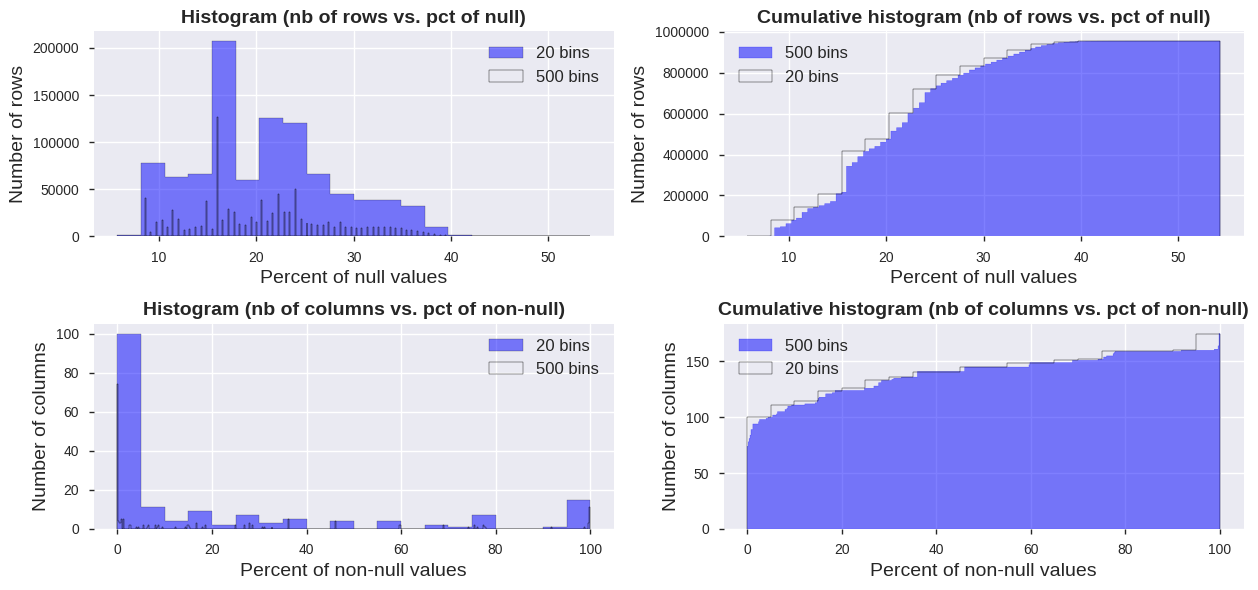

In [0]:
# Vizualisation of missing values
# columns vs. xx % null/non-null values

nb_col_non_null = desc_df_all.loc["count"].values.astype(int) # nb of null for each col
pct_col_non_null = nb_col_non_null*100/df.shape[0] # pct of null for each col

nb_row_non_null = df.count(axis=1).values.astype(int) # nb of null for each row
pct_row_non_null = nb_row_non_null*100/df.shape[1] # pct of null for each row

fig1 = plt.figure(figsize = (13,6))

ax1 = plt.subplot(2,2,1)
ax1.hist(pct_row_non_null, bins=20, density=False, alpha =0.5,
         histtype='stepfilled', cumulative=False,
         fc='blue', ec='k', label='20 bins')
ax1.hist(pct_row_non_null, bins=500, density=False,
         histtype='step', cumulative=False,
         fc='blue', ec='k', label='500 bins')
plt.xlabel("Percent of null values", fontsize=14)
plt.ylabel("Number of rows", fontsize=14)
#plt.xlim(40, 160), plt.ylim(0, 0.03)
#plt.text(0,my_y_lim*0.05, "blabla", fontsize=14)
plt.title("Histogram (nb of rows vs. pct of null)", 
          fontsize=14, fontweight='bold')
plt.grid(True), plt.legend(loc='upper right', fontsize=12)

ax2 = plt.subplot(2,2,2)
ax2.hist(pct_row_non_null, bins=500, fc='b', alpha =0.5, ec='b', 
         density=False, histtype='stepfilled', cumulative=True,
         label='500 bins')
ax2.hist(pct_row_non_null, bins = 20, fc = 'None', ec = 'k', 
         density=False, histtype='step', cumulative=True, 
         label='20 bins')
plt.xlabel("Percent of null values", fontsize=14)
plt.ylabel("Number of rows", fontsize=14)
#plt.xlim(40, 160), plt.ylim(0, 0.03)
#plt.text(0,my_y_lim*0.05, "blabla", fontsize=14)
plt.title("Cumulative histogram (nb of rows vs. pct of null)",
          fontsize=14, fontweight='bold')
plt.grid(True), plt.legend(loc='upper left',fontsize=12)

# Vizualisation of existing values
# columns with xx % non-null value

nb_non_null = desc_df_all.loc["count"].values.astype(int) # nb of null for each col
pct_non_null = nb_non_null*100/df.shape[0] # pct of null for each col

ax1 = plt.subplot(2,2,3)
ax1.hist(pct_col_non_null, bins=20, density=False, alpha =0.5,
         histtype='stepfilled', cumulative=False,
         fc='blue', ec='k', label='20 bins')
ax1.hist(pct_col_non_null, bins=500, density=False,
         histtype='step', cumulative=False,
         fc='blue', ec='k', label='500 bins')
plt.xlabel("Percent of non-null values", fontsize=14)
plt.ylabel("Number of columns", fontsize=14)
#plt.xlim(40, 160), plt.ylim(0, 0.03)
#plt.text(0,my_y_lim*0.05, "blabla", fontsize=14)
plt.title("Histogram (nb of columns vs. pct of non-null)", 
          fontsize=14, fontweight='bold')
plt.grid(True), plt.legend(fontsize=12)

ax2 = plt.subplot(2,2,4)
ax2.hist(pct_col_non_null, bins=500, fc='b', alpha =0.5, ec='b', 
         density=False, histtype='stepfilled', cumulative=True,
         label='500 bins')
ax2.hist(pct_col_non_null, bins = 20, fc = 'None', ec = 'k', 
         density=False, histtype='step', cumulative=True, 
         label='20 bins')
plt.xlabel("Percent of non-null values", fontsize=14)
plt.ylabel("Number of columns", fontsize=14)
#plt.xlim(40, 160), plt.ylim(0, 0.03)
#plt.text(0,my_y_lim*0.05, "blabla", fontsize=14)
plt.title("Cumulative histogram (nb of columns vs. pct of non-null)",
          fontsize=14, fontweight='bold')
plt.grid(True), plt.legend(loc='upper left',fontsize=12)
fig1.tight_layout()

plt.show()

In [0]:
# Producing table with number and pct of missing/non-missing values for each column
df_null = desc_df_all.loc[['null','count']].T.sort_values(by = 'count')
df_null["pct_null"] = df_null["null"]*100/df.shape[0]
df_null["pct_non_null"] = df_null["count"]*100/df.shape[0]
#df_null["total"] = df_null["count"]+df_null["null"]
df_null = df_null.sort_values(by = 'count')
pd.options.display.float_format = '{:.2f}'.format
df_null.head(7)

,null,count,pct_null,pct_non_null
allergens_en,954463,0.00,100.00,0.00
no_nutriments,954463,0.00,100.00,0.00
-caproic-acid_100g,954463,0.00,100.00,0.00
-elaidic-acid_100g,954463,0.00,100.00,0.00
-mead-acid_100g,954463,0.00,100.00,0.00
-erucic-acid_100g,954463,0.00,100.00,0.00
-lignoceric-acid_100g,954463,0.00,100.00,0.00


In [0]:
# Checking the number and extracting indexes of 'null' rows, if existing
row_dropna_df = df.dropna(how = 'all', axis = 0, inplace = False)
rows_null = [i for i in df.columns if i not in row_dropna_df.columns]
len(rows_null), rows_null

(0, [])

In [0]:
# Duplicated rows (on all columns, on "code", on "product_name" and "quantity")
dup_all_ser = df.duplicated(subset=None, keep='first')

In [0]:
# Checking the number and extracting names of 'null' columns, if existing
col_dropna_df = df.dropna(how = 'all', axis = 1, inplace = False)
cols_null = [col for col in df.columns if col not in col_dropna_df.columns]
len(cols_null), cols_null

(14,
 ['cities',
  'allergens_en',
  'no_nutriments',
  'ingredients_from_palm_oil',
  'ingredients_that_may_be_from_palm_oil',
  '-caproic-acid_100g',
  '-lignoceric-acid_100g',
  '-melissic-acid_100g',
  '-elaidic-acid_100g',
  '-gondoic-acid_100g',
  '-mead-acid_100g',
  '-erucic-acid_100g',
  '-nervonic-acid_100g',
  'water-hardness_100g'])

In [0]:
# Checking number and extracting names of columns with more than 2.5% missing values ('null')
cols_miss_val = df_null[df_null['pct_non_null']<2.5].index
len(cols_miss_val), cols_miss_val

(94,
 Index(['allergens_en', 'no_nutriments', '-caproic-acid_100g', '-elaidic-acid_100g', '-mead-acid_100g', '-erucic-acid_100g', '-lignoceric-acid_100g', '-gondoic-acid_100g', 'cities', 'water-hardness_100g', 'ingredients_that_may_be_from_palm_oil', 'ingredients_from_palm_oil', '-melissic-acid_100g', '-nervonic-acid_100g', '-behenic-acid_100g', '-dihomo-gamma-linolenic-acid_100g', '-butyric-acid_100g', '-caprylic-acid_100g', '-myristic-acid_100g', '-stearic-acid_100g', '-montanic-acid_100g', 'chlorophyl_100g', '-cerotic-acid_100g', '-gamma-linolenic-acid_100g', '-palmitic-acid_100g', '-arachidic-acid_100g', 'phylloquinone_100g', 'glycemic-index_100g', '-capric-acid_100g', '-lauric-acid_100g', '-maltose_100g', 'nucleotides_100g', '-maltodextrins_100g', 'carnitine_100g', '-arachidonic-acid_100g', '-oleic-acid_100g', 'beta-glucan_100g', 'additives', 'choline_100g', 'serum-proteins_100g', 'inositol_100g', 'omega-9-fat_100g', 'casein_100g', '-glucose_100g', 'chromium_100g', 'molybdenum_100

In [0]:
# Rows with erroneous code
# Rows with erroneous code
crucial_col = []
rows_miss_val = 
len(rows_miss_val), rows_miss_val

(94,
 Index(['allergens_en', 'no_nutriments', '-caproic-acid_100g', '-elaidic-acid_100g', '-mead-acid_100g', '-erucic-acid_100g', '-lignoceric-acid_100g', '-gondoic-acid_100g', 'cities', 'water-hardness_100g', 'ingredients_that_may_be_from_palm_oil', 'ingredients_from_palm_oil', '-melissic-acid_100g', '-nervonic-acid_100g', '-behenic-acid_100g', '-dihomo-gamma-linolenic-acid_100g', '-butyric-acid_100g', '-caprylic-acid_100g', '-myristic-acid_100g', '-stearic-acid_100g', '-montanic-acid_100g', 'chlorophyl_100g', '-cerotic-acid_100g', '-gamma-linolenic-acid_100g', '-palmitic-acid_100g', '-arachidic-acid_100g', 'phylloquinone_100g', 'glycemic-index_100g', '-capric-acid_100g', '-lauric-acid_100g', '-maltose_100g', 'nucleotides_100g', '-maltodextrins_100g', 'carnitine_100g', '-arachidonic-acid_100g', '-oleic-acid_100g', 'beta-glucan_100g', 'additives', 'choline_100g', 'serum-proteins_100g', 'inositol_100g', 'omega-9-fat_100g', 'casein_100g', '-glucose_100g', 'chromium_100g', 'molybdenum_100

In [0]:
Diff(rejected_variables_90,cols_miss_val)

({'calcium_100g',
  'carbohydrates_100g',
  'cholesterol_100g',
  'fat_100g',
  'fiber_100g',
  'iron_100g',
  'nutrition-score-fr_100g',
  'nutrition-score-uk_100g',
  'polyunsaturated-fat_100g',
  'potassium_100g',
  'proteins_100g',
  'salt_100g',
  'sodium_100g',
  'sugars_100g',
  'vitamin-a_100g',
  'vitamin-c_100g'},
 {'-alpha-linolenic-acid_100g',
  '-arachidonic-acid_100g',
  '-behenic-acid_100g',
  '-butyric-acid_100g',
  '-caproic-acid_100g',
  '-caprylic-acid_100g',
  '-dihomo-gamma-linolenic-acid_100g',
  '-eicosapentaenoic-acid_100g',
  '-elaidic-acid_100g',
  '-erucic-acid_100g',
  '-gondoic-acid_100g',
  '-lignoceric-acid_100g',
  '-maltodextrins_100g',
  '-mead-acid_100g',
  '-melissic-acid_100g',
  '-montanic-acid_100g',
  '-myristic-acid_100g',
  '-nervonic-acid_100g',
  '-stearic-acid_100g',
  'additives',
  'allergens_en',
  'cities',
  'collagen-meat-protein-ratio_100g',
  'energy-from-fat_100g',
  'ingredients_from_palm_oil',
  'ingredients_from_palm_oil_tags',
 

__Main conclusions__ :
 - 14 columns with no data
 - 78 columns with very few data (less than 2.5 %)
 - 0 row with no data
 -  rows with crucial data missing

#### Dealing with missing values

In [0]:
df_clean = df.copy(deep = True)

In [0]:
# Eliminating rows with crucial data missing
# (no null row to eliminate)
df_clean = df_clean.drop(columns = col_miss_val)
df_clean.shape

In [0]:
# Eliminating columns with more than 2.5% missing values
# (no null row to eliminate)
df_clean = df_clean.drop(columns = col_miss_val)
df_clean.shape

fdcxwsfcxfgvxc

### Duplicates

#### -> dealing with duplicates


- retirer les produits sans noms
- garder seulement les items ayant plus de XX % de données renseignées (éliminer d'abord les lignes)

- respect des bornes (0-100g)
    - combien d'entrées concernés
    - facile à corriger ou pas ?

- outliers exceeding 3 sigmas
    - nombreux ou pas ?
    - traitement au cas par cas éventuellement

- trouver la structure des données/catégorisation des colonnes
- élimination ou sélection de certaines colonnes ?
- vérifier la cohérence des infos (calories/joules et somme des énergies des différentes classes)

- reconstruire les valeurs manquantes

Exploration
Analyse univariée :
- box plot, violin plot, nuages de dispersion
- hisogrammes pour différentes variables
- produits ayant le plus grand nombres d'ingrédients

Analyse mulivariée :
- matrice de corrélation pour plusieurs variables
- diagramme de dispersion en fonction du nutriscore pour pls groupes de 2 variables

### Outliers

#### -> dealing with outliers

### Rescaling data

In [0]:
# separating numerical data from object data
num_df = df.select_dtypes(include="number")
obj_df = df.select_dtypes(include="object")
df.shape, num_df.shape, obj_df.shape

In [0]:
# # no need for the datetime columns
# # cols = [c for c in df.columns if c.lower()[-9:] != '_datetime' and c.lower()[-2:] != '_t']
# cols = [c for c in df.columns if c.lower()[-5:] == '_100g']
# cols.append('code')
# df = df[cols]

# # eliminate null values
# df = df[(df['energy_100g'] != 0) & (df['nutrition-score-fr_100g'] != 0)]

# # we keep only column 70% filled
# thresh = len(df) * .3
# df.dropna(thresh = thresh, axis = 1, inplace = True)

# df = df.fillna(0)

# df = df.round(5)

### Define categories

In [0]:
# posteDep = {
#     'EMPLOI': 'Entrées',
#     'PAIE': 'Entrées',
#     'SAADNA': 'E